# Bono 1


In [36]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import numpy as np

## Datos de entrenamiento 
Corresponden al comportamiento de la potenica según la señal de voltaje suministrada en una microturbina de gas.

In [37]:
carpeta = r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\bono\train"
lis = []

# leer todos los archivos de la carpeta train
for arch in os.listdir(carpeta):
    
    archivo = os.path.join(carpeta, arch)
    data = pd.read_csv(archivo)
    data['exp'] = arch.replace('.csv', '') #agregar indicatvo del experimento 
    lis.append(data)
# Combinar todos los DataFrames 
train = pd.concat(lis, ignore_index=True)
train





,time,input_voltage,el_power,exp
0,810.07028,10.00,1228.791720,ex_1
1,811.06938,10.00,1223.041745,ex_1
2,812.06848,10.00,1244.960866,ex_1
3,813.06758,10.00,1229.259058,ex_1
4,814.06668,10.00,1248.117024,ex_1
...,...,...,...,...
52935,12632.84000,7.24,2358.536920,ex_9
52936,12633.84000,7.24,2481.489028,ex_9
52937,12634.84000,7.24,2327.054441,ex_9
52938,12635.84000,7.24,2451.061029,ex_9


## Análisis Expoloratorio 


Exp ex_1 - Media: 2162.4278742355946, Max: 3249.89121738983, Min: 932.837260159588
Exp ex_1 - Unique input_voltage: [10.  3.]


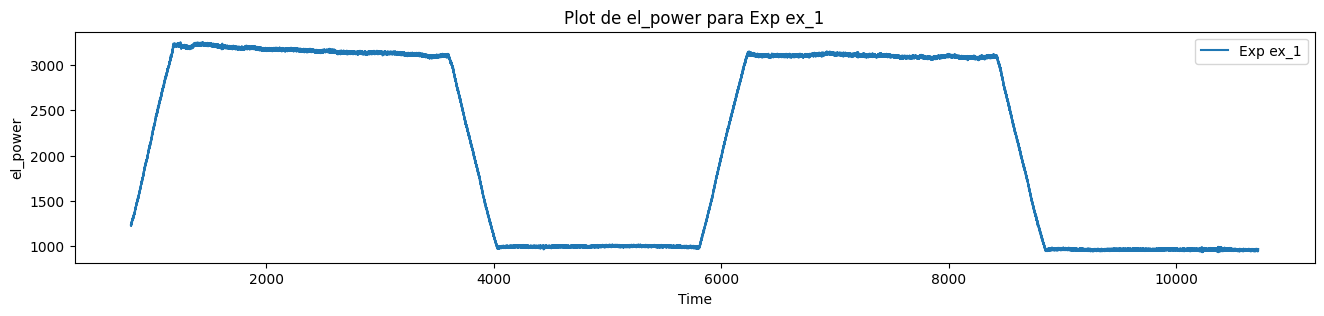

Exp ex_20 - Media: 1623.2634935180495, Max: 3182.43106085729, Min: 1097.03079149941
Exp ex_20 - Unique input_voltage: [ 3.   5.   7.5 10. ]


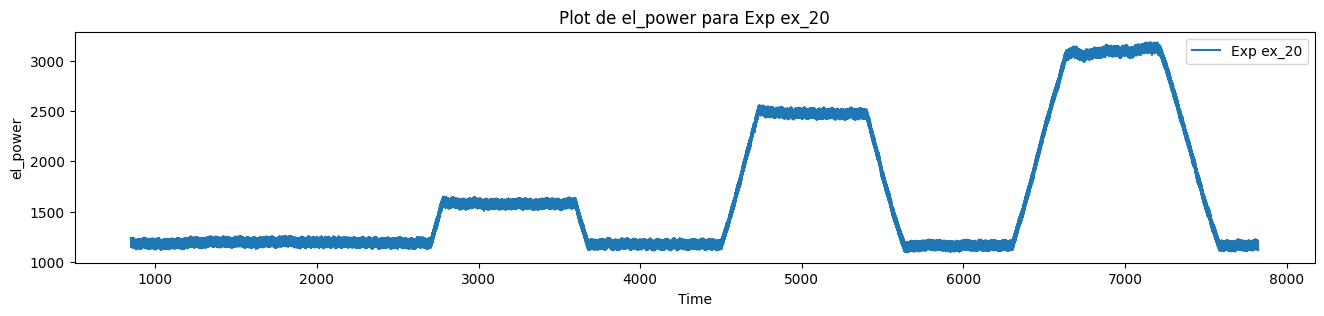

Exp ex_21 - Media: 1576.4602774140983, Max: 3191.96680243227, Min: 1045.54102016552
Exp ex_21 - Unique input_voltage: [ 3.   5.   7.5 10. ]


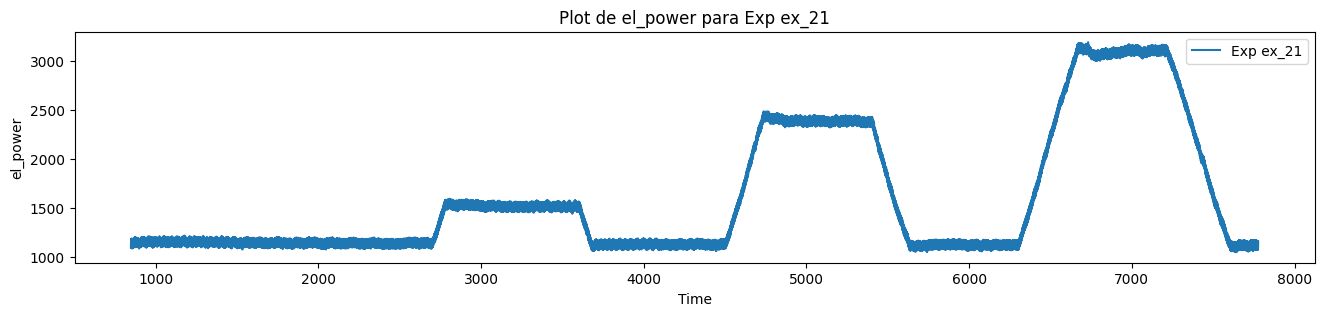

Exp ex_23 - Media: 1899.2318467052246, Max: 3193.84635095489, Min: 1053.21830642725
Exp ex_23 - Unique input_voltage: [3.         3.36842105 3.73684211 4.10526316 4.47368421 4.84210526
 5.21052632 5.57894737 5.94736842 6.31578947 6.68421053 7.05263158
 7.42105263 7.78947368 8.15789474 8.52631579 8.89473684 9.26315789
 9.63157895]


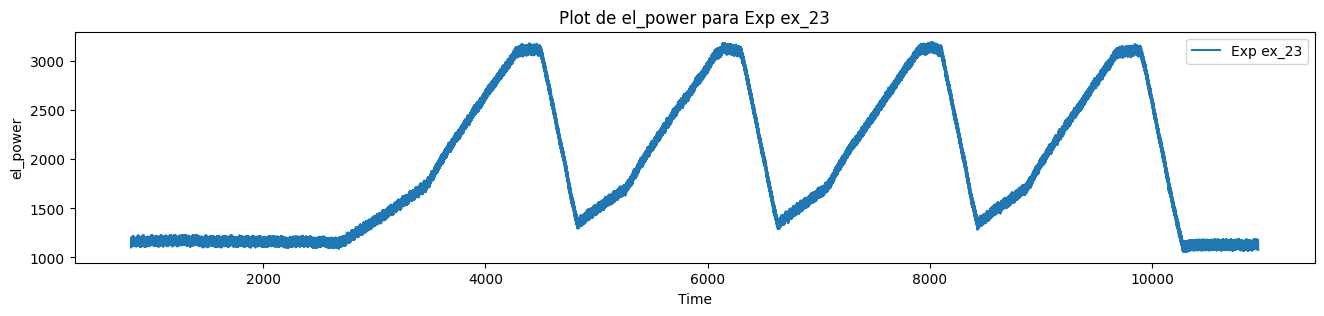

Exp ex_24 - Media: 1805.375103910433, Max: 3191.10141553597, Min: 1054.17524996577
Exp ex_24 - Unique input_voltage: [ 3.          3.36842105  3.73684211  4.10526316  4.47368421  4.84210526
  5.21052632  5.57894737  5.94736842  6.31578947  6.68421053  7.05263158
  7.42105263  7.78947368  8.15789474  8.52631579  8.89473684  9.26315789
  9.63157895 10.        ]


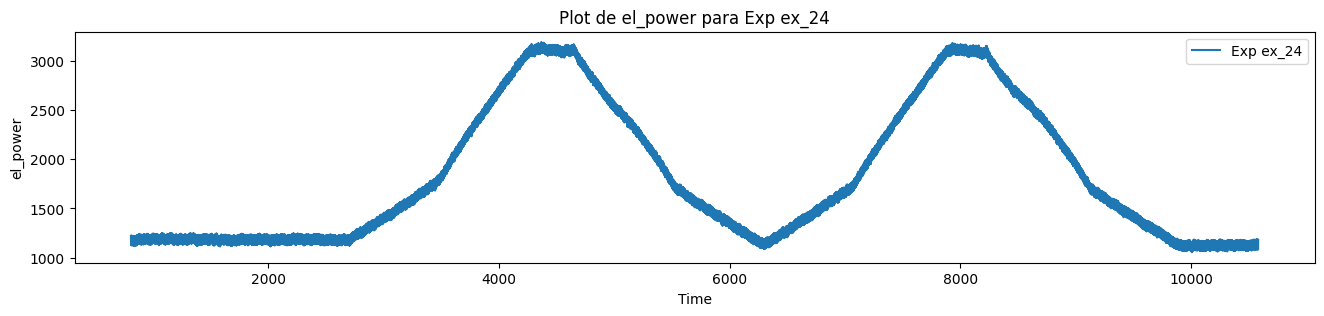

Exp ex_9 - Media: 1828.5484538476937, Max: 2511.69826204778, Min: 1204.20567057897
Exp ex_9 - Unique input_voltage: [3.445 3.855 4.305 4.785 5.29  5.79  6.245 6.615 6.88  7.055 7.165 7.24 ]


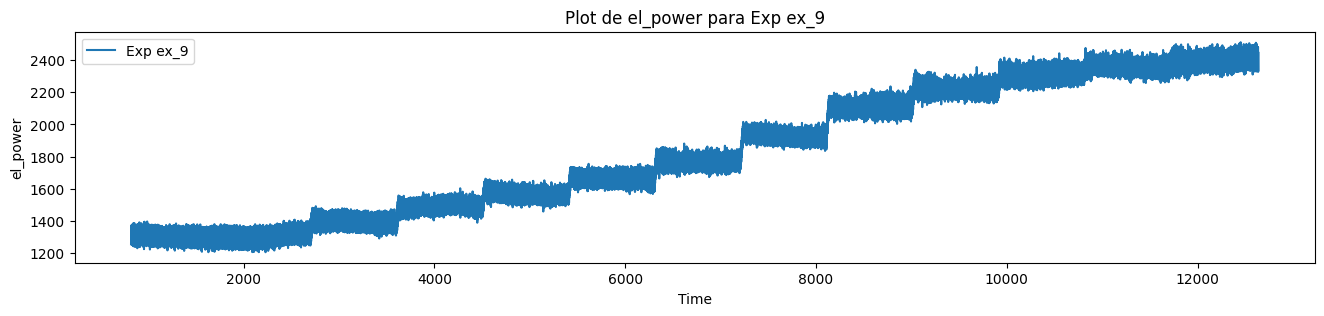

In [38]:
for exp_value in train['exp'].unique():
    # filtrar por experimento
    subset = train[train['exp'] == exp_value]
    
    # Calcula estadísticas para la variable de respuesta 
    mean_el_power = subset['el_power'].mean()
    max_el_power = subset['el_power'].max()
    min_el_power = subset['el_power'].min()
    std_el_power = subset['el_power'].std()
    
    # Obtiene los valores únicos de la variable input_voltage
    unique_input_voltage = subset['input_voltage'].unique()
    
    print(f"Exp {exp_value} - Media: {mean_el_power}, Max: {max_el_power}, Min: {min_el_power}")
    print(f"Exp {exp_value} - Unique input_voltage: {unique_input_voltage}")
    
    #  gráficos
    plt.figure(figsize=(16, 3))  
    plt.plot(subset['time'], subset['el_power'], label=f'Exp {exp_value}')
    plt.title(f'Plot de el_power para Exp {exp_value}')
    plt.xlabel('Time')
    plt.ylabel('el_power')
    plt.legend()
    plt.show()

Para el experimento 1, se realizó un cambio de voltaje entre 3 y 10.  se evidencia que la potencia se mantiene constante minetras no haya cambios de potencia. 

En el experiento 20 y 21 se utlizaron las mismas condiciones de voltaje, una serie cuadrada, iniciando con voltaje 3, subía y volvía a su base. los valores alos que se aumentó fueron   5,  7.5, 10. de forma ascendente. 

En el experimento 23 se aumentó en 4 ocaciones el voltaje gradualmente de 3 a 9.6 y luego bajandolo drasticamnete nuevamente a 3. 

En el experimento 24 se amumento y disminuyó el voltaje gardualmente dos veces.  

En el experiemento 9 se hizo el auento de manera escalonada y se ve como mientras se conserva el voltaje la potencia se mantiene constante

## Modelos 
Para cada experimento, es decir cada conjunto de datos de entrenamiento se realizaran 4 modelos : 
    -Suavización exponencial de primer orden
    -Suavización exponencial de segundo orden
    -Suavización exponencial de segundo orden con actualización del factor de descuento
    -Holt-Winters

En total se tendran 24 modelos diferentes que se guardaran en el diccionario  `modelos`

In [39]:
modelos = {}

# para cada experiemnto 
for exp_value in train['exp'].unique():
    
    subset_train = train[train['exp'] == exp_value]
    # Extrae la serie temporal de 'el_power'
    y_train = subset_train['el_power']
    
    # Suavización exponencial de primer orden
    model_1st_order = SimpleExpSmoothing(y_train).fit()
    modelos[f'1st_order_exp_{exp_value}'] = model_1st_order
    
    # Suavización exponencial de segundo orden
    model_2nd_order = ExponentialSmoothing(y_train, trend='add').fit()
    modelos[f'2nd_order_exp_{exp_value}'] = model_2nd_order
    
    # Suavización exponencial de segundo orden con  factor de descuento
    model_2nd_order_discount = ExponentialSmoothing(y_train, trend='add', damped_trend=True).fit()
    modelos[f'2nd_order_discount_exp_{exp_value}'] = model_2nd_order_discount
    
    # Holt-Winters (suavización de triple nivel, aunque se usa solo el componente de tendencia)
    model_holt_winters = ExponentialSmoothing(y_train, trend='add', seasonal=None).fit()
    modelos[f'holt_winters_exp_{exp_value}'] = model_holt_winters

## Datos de Prueba 
Se toman los experiemntos 4 y 22 como set de prueba 

In [40]:
carpeta = r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\bono\test"
lis = []

# leer todos los archivos de la carpeta train
for arch in os.listdir(carpeta):
    
    archivo = os.path.join(carpeta, arch)
    data = pd.read_csv(archivo)
    data['exp'] = arch.replace('.csv', '') #agregar indicatvo del experimento 
    lis.append(data)
# Combinar todos los DataFrames en uno solo
test = pd.concat(lis, ignore_index=True)
test


,time,input_voltage,el_power,exp
0,880.300000,3.0,1193.140713,ex_22
1,881.300000,3.0,1107.066421,ex_22
2,882.300000,3.0,1180.406767,ex_22
3,883.300000,3.0,1095.551498,ex_22
4,884.300000,3.0,1177.073719,ex_22
...,...,...,...,...
18280,10541.535214,3.0,2373.250274,ex_4
18281,10542.534511,3.0,2429.362888,ex_4
18282,10543.533807,3.0,2369.397892,ex_4
18283,10544.533103,3.0,2419.959332,ex_4


<Figure size 1000x600 with 0 Axes>

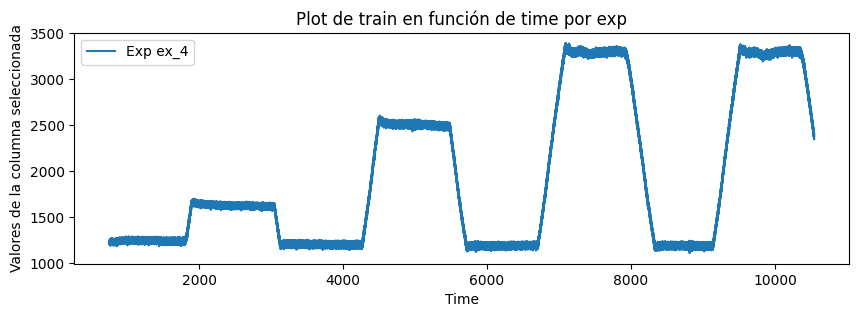

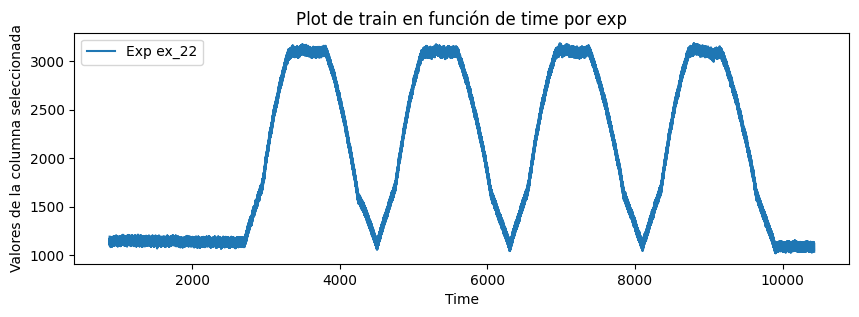

In [41]:
test= test.sort_values(by='time')
plt.figure(figsize=(10,6))

# Recorre cada valor único de la columna 'exp'
for exp_value in test['exp'].unique():
    plt.figure(figsize=(10,3))
    # Filtra los datos para cada valor de 'exp'
    subset = test[test['exp'] == exp_value]
    
    # Haz el plot con 'time' en el eje X y las demás columnas en Y
    plt.plot(subset['time'], subset['el_power'], label=f'Exp {exp_value}')  # Reemplaza 'some_column' con la columna de interés
    

    # Añadir título y etiquetas
    plt.title('Plot de train en función de time por exp')
    plt.xlabel('Time')
    plt.ylabel('Valores de la columna seleccionada')

    # Añadir la leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()

Para el experimento 4 se puede decir que los modelos que mejor se ajustaran serán aquellos realizados para los modelos 20 y 21 pues conservan la estructura similar en donde se aumenta, baja y luego aumneta un poco más, haciendo una oscilación caad avez más amplia, con una tendecia a la alza. 

Para el experimneto 22, aunque en los experimentos de entrenamiento no se evidencia un patrón similar podemos inferir que tendrá cercania con las series expuestas en los experimentos 23 y 24.



## Prueba 
Se aplicó cada modelo del diccionario modelos para cada conjunto de prueba y según ña metrica RMSE se determinará cual es el mejor y si las inferencias realizadas anteriormente fueorn válidas. 

Se mostrará la gráfica con los valores reales y la preddición, además del valor de la métrica RMSE(debajo del título)

In [52]:

resultados = {}
mejores_modelos = {}

# Para cada experimento de prueba se hará la aplicación de los 24 modelos entrenados
for exp_value in test['exp'].unique():
    
    subset_test = test[test['exp'] == exp_value]
    y_test = subset_test['el_power']
    print(f"EXPERIMENTO {exp_value}")
    
    mejor_rmse = float('inf')
    mejor_modelo = None
    
    for model_name, model in modelos.items():
        
        # Realiza la predicción 
        pred = model.predict(start=0, end=len(y_test) - 1)
        
        # Calcular RMSE
        rmse = np.sqrt(np.mean((pred - y_test) ** 2))
        
        if exp_value not in resultados:
            resultados[exp_value] = []
        resultados[exp_value].append((model_name, rmse))
        print(f"Modelo: {model_name} - RMSE: {rmse:.4f}")
        
    
        if rmse < mejor_rmse:
            mejor_rmse = rmse
            mejor_modelo = model_name
    
    mejores_modelos[exp_value] = (mejor_modelo, mejor_rmse)
    


EXPERIMENTO ex_4
Modelo: 1st_order_exp_ex_1 - RMSE: 375.0486
Modelo: 2nd_order_exp_ex_1 - RMSE: 375.0457
Modelo: 2nd_order_discount_exp_ex_1 - RMSE: 375.0433
Modelo: holt_winters_exp_ex_1 - RMSE: 375.0457
Modelo: 1st_order_exp_ex_20 - RMSE: 203.7595
Modelo: 2nd_order_exp_ex_20 - RMSE: 290.3479
Modelo: 2nd_order_discount_exp_ex_20 - RMSE: 209.0946
Modelo: holt_winters_exp_ex_20 - RMSE: 290.3479
Modelo: 1st_order_exp_ex_21 - RMSE: 237.0531
Modelo: 2nd_order_exp_ex_21 - RMSE: 256.3624
Modelo: 2nd_order_discount_exp_ex_21 - RMSE: 234.8606
Modelo: holt_winters_exp_ex_21 - RMSE: 256.3624
Modelo: 1st_order_exp_ex_23 - RMSE: 232.2924
Modelo: 2nd_order_exp_ex_23 - RMSE: 303.4507
Modelo: 2nd_order_discount_exp_ex_23 - RMSE: 246.6412
Modelo: holt_winters_exp_ex_23 - RMSE: 303.4507
Modelo: 1st_order_exp_ex_24 - RMSE: 226.7208
Modelo: 2nd_order_exp_ex_24 - RMSE: 150.5894
Modelo: 2nd_order_discount_exp_ex_24 - RMSE: 214.9609
Modelo: holt_winters_exp_ex_24 - RMSE: 150.5894
Modelo: 1st_order_exp_ex_9 

El mejor modelo para Exp ex_4 es 2nd_order_exp_ex_24 con un RMSE de 150.59


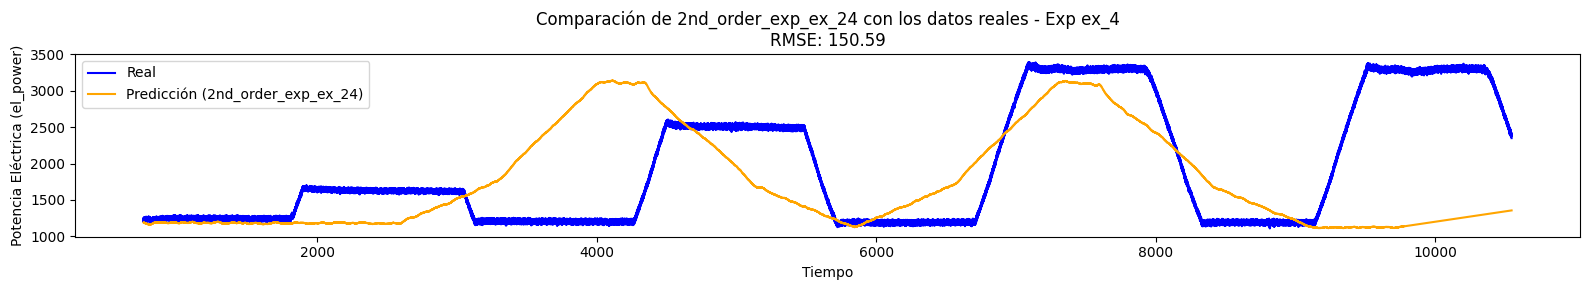

El mejor modelo para Exp ex_22 es 1st_order_exp_ex_20 con un RMSE de 787.93


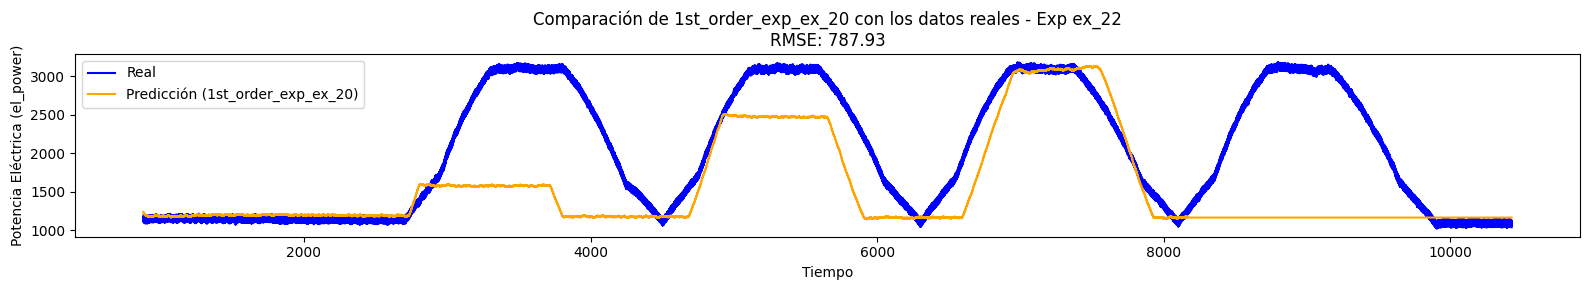

In [51]:
#Mejor modelo para cada subconjunto de prueba
for exp_value, (mejor_modelo, mejor_rmse) in mejores_modelos.items():
    
    print(f"El mejor modelo para Exp {exp_value} es {mejor_modelo} con un RMSE de {mejor_rmse:.2f}")
    
    subset_test = test[test['exp'] == exp_value]
    y_test = subset_test['el_power']
    time_test = subset_test['time']
    
    model = modelos[mejor_modelo]
    pred = model.predict(start=0, end=len(y_test) - 1)
    #Gráfica
    plt.figure(figsize=(16, 3)) 
    plt.plot(time_test, y_test, label='Real', color='blue')
    plt.plot(time_test, pred, label=f'Predicción ({mejor_modelo})', color='orange')
    plt.title(f"Comparación de {mejor_modelo} con los datos reales - Exp {exp_value}\nRMSE: {mejor_rmse:.2f}")
    plt.xlabel('Tiempo')
    plt.ylabel('Potencia Eléctrica (el_power)')
    plt.legend()
    plt.tight_layout()
    plt.show()

Los reusltados nos muestran que para el experiemnto 4 el mejor modelo fue la ``suavización exponencial de segundo orden del exp. 24` y para el experimento 22 fue la `suavización exponencial de primer orden del experiemnto 20`. Los resulatdos no fueron los esperados a partir de analisis visual hecho anteriormente. Además los modelos que mejor se ajustaron a cada subconjunto de test no siguen el mismo patron en el tiempo que cualquiera de los experiemntos utilizados en el entrenamiento de los modelos por lo que era de esperarse que la serie real y la predicción no fueran parecidas 